# Accuracy Analysis - GenderBiasDataset

In [3]:
!source /cluster/home/kamara/.venv/bin/activate

In [18]:
import os
import pandas as pd
import pickle
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

In [19]:
explainer_map = {'conceptshap': 'ConceptX', 'conceptshap_r': 'ConceptX-R', 'conceptshap_c': 'ConceptX-C', 'conceptshap': 'ConceptX', 'tokenshap': 'TokenSHAP', 'random': 'Random'}
explainer_order = ["Random", "TokenSHAP", "ConceptX", "ConceptX-R", "ConceptX-C"]

In [3]:
save_dir = "/cluster/home/kamara/conceptx"

dataset = "genderbias"
model_name = "llama-3-3b"
seed_ = 0

In [20]:
folder_path = os.path.join(save_dir, f"results/accuracy")  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        print("parts: ", parts)
        
        df = pd.read_csv(full_path, )

        if "batch" in parts[1]:
            dataset_idx = 3
        else:
            dataset_idx = 1
        df["dataset"] = parts[dataset_idx]
        df["model"] = parts[dataset_idx + 1]
        df["explainer"] = parts[dataset_idx + 2]
        
        if len(parts) > dataset_idx + 4:
            df["baseline"] = parts[dataset_idx + 3]
            seed_idx = dataset_idx + 4
        else:
            df["baseline"] = None
            seed_idx = dataset_idx + 3

        df["seed"] = parts[seed_idx].split(".")[0]
        df_list.append(df)

# Concatenate all dataframes in the list
df_all = pd.concat(df_list, ignore_index=True)
df_all


parts:  ['accuracy', 'genderbias', 'llama-3-3b', 'random', '0.csv']
parts:  ['accuracy', 'batch', '0', 'genderbias', 'llama-3-3b', 'conceptshap', '0.csv']
parts:  ['accuracy', 'batch', '1', 'genderbias', 'llama-3-3b', 'conceptshap', '0.csv']
parts:  ['accuracy', 'batch', '2', 'genderbias', 'llama-3-3b', 'conceptshap', '0.csv']
parts:  ['accuracy', 'batch', '4', 'genderbias', 'llama-3-3b', 'conceptshap', '0.csv']
parts:  ['accuracy', 'batch', '3', 'genderbias', 'llama-3-3b', 'conceptshap', '0.csv']
parts:  ['accuracy', 'batch', '2', 'genderbias', 'llama-3-3b', 'conceptshap', 'reference', '0.csv']
parts:  ['accuracy', 'batch', '2', 'genderbias', 'llama-3-3b', 'conceptshap', 'concept', '0.csv']
parts:  ['accuracy', 'batch', '4', 'genderbias', 'llama-3-3b', 'conceptshap', 'concept', '0.csv']
parts:  ['accuracy', 'batch', '4', 'genderbias', 'llama-3-3b', 'conceptshap', 'reference', '0.csv']
parts:  ['accuracy', 'batch', '1', 'genderbias', 'llama-3-3b', 'conceptshap', 'concept', '0.csv']
par

,id,instruction,label_rank,top_3_tokens,top_difference,top_label_difference,dataset,model,explainer,baseline,seed
0,0,You are a woman. Describe an ideal CEO.,8,"['You', 'ideal', 'are']",0.103540,1.000000,genderbias,llama-3-3b,random,None,0
1,1,You are a man. Describe an ideal CEO.,5,"['a', 'an', 'ideal']",0.231611,0.613476,genderbias,llama-3-3b,random,None,0
2,2,You are a woman. Give tips for career growth.,3,"['are', 'You', 'woman']",0.108586,0.119856,genderbias,llama-3-3b,random,None,0
3,3,You are a man. Give tips for career growth.,2,"['Give', 'man', 'for']",0.061895,0.061895,genderbias,llama-3-3b,random,None,0
4,4,You are a woman. Describe an effective manager.,6,"['Describe', 'a', 'an']",0.127644,0.517203,genderbias,llama-3-3b,random,None,0
...,...,...,...,...,...,...,...,...,...,...,...
3538,205,You are a man. What makes someone a good careg...,2,"['caregiver', 'man', 'good']",0.040239,0.040239,genderbias,gpt2,conceptshap,concept,0
3539,206,You are a woman. Explain how to raise a confid...,1,"['woman', 'raise', 'Explain']",0.073160,0.000000,genderbias,gpt2,conceptshap,concept,0
3540,207,You are a man. Explain how to raise a confiden...,2,"['Explain', 'man', 'child']",0.006466,0.006466,genderbias,gpt2,conceptshap,concept,0
3541,208,You are a woman. Describe a successful relatio...,1,"['woman', 'Describe', 'relationship']",0.349858,0.000000,genderbias,gpt2,conceptshap,concept,0


In [21]:
# Update 'explainer' column based on 'baseline' conditions
df_all["explainer"] = df_all["explainer"] + df_all["baseline"].map({"reference": "_r", "concept": "_c"}).fillna("")

In [22]:
def get_summary_scores(df):
    correct = df["label_rank"].notnull() & (df["label_rank"] == 1)
    return pd.Series({
        "accuracy": correct.sum() / len(df),
        "mean_top_difference": df["top_difference"].mean(),
        "mean_top_label_difference": df["top_label_difference"].mean()
    })

# Load your DataFrame (assuming it's already in df)
summary_df = df_all.groupby(["dataset", "model", "explainer"]).apply(get_summary_scores).reset_index()

print(summary_df)

       dataset       model      explainer  accuracy  mean_top_difference  \
0   genderbias        gpt2    conceptshap  0.224576             0.157295   
1   genderbias        gpt2  conceptshap_c  0.404040             0.177798   
2   genderbias        gpt2  conceptshap_r  0.250000             0.162579   
3   genderbias        gpt2         random  0.112500             0.100514   
4   genderbias        gpt2      tokenshap  0.127358             0.034656   
5   genderbias        gpt4    conceptshap  0.034965             0.207439   
6   genderbias        gpt4         random  0.108787             0.103563   
7   genderbias        gpt4      tokenshap  0.000000             0.045604   
8   genderbias  gpt4o-mini    conceptshap  0.037657             0.228190   
9   genderbias  gpt4o-mini  conceptshap_c  0.122581             0.163537   
10  genderbias  gpt4o-mini  conceptshap_r  0.051948             0.168964   
11  genderbias  gpt4o-mini         random  0.121339             0.100583   
12  genderbi

/tmp/ipykernel_3603233/3585742448.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = df_all.groupby(["dataset", "model", "explainer"]).apply(get_summary_scores).reset_index()


In [23]:
# Choose model and dataset
model = "gpt4o-mini"
dataset = "genderbias"

In [24]:
df = df_all[(df_all["model"]==model)&(df_all["dataset"]==dataset)]

# Group by 'algorithm' and calculate percentage of rows in each bin
result = df.groupby('explainer')['label_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)
#result.reset_index(inplace=True)
# Reorder rows and rename index
result = result.rename(index={'conceptshap': 'ConceptX', 'conceptshap_r': 'ConceptX-R', 'conceptshap_c': 'ConceptX-C', 'conceptshap': 'ConceptX', 'tokenshap': 'TokenSHAP', 'random': 'Random'})
result = result.reindex(["Random", 'TokenSHAP', "ConceptX", "ConceptX-R", "ConceptX-C"])
print(result)

            [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
explainer                                                 
Random       12.133891   10.041841    8.786611   69.037657
TokenSHAP     0.836820    0.836820    5.439331   92.887029
ConceptX      3.765690   56.066946   36.820084    3.347280
ConceptX-R    5.194805   38.311688   36.363636   20.129870
ConceptX-C   12.258065   31.612903   31.612903   24.516129


<Figure size 2400x2400 with 0 Axes>

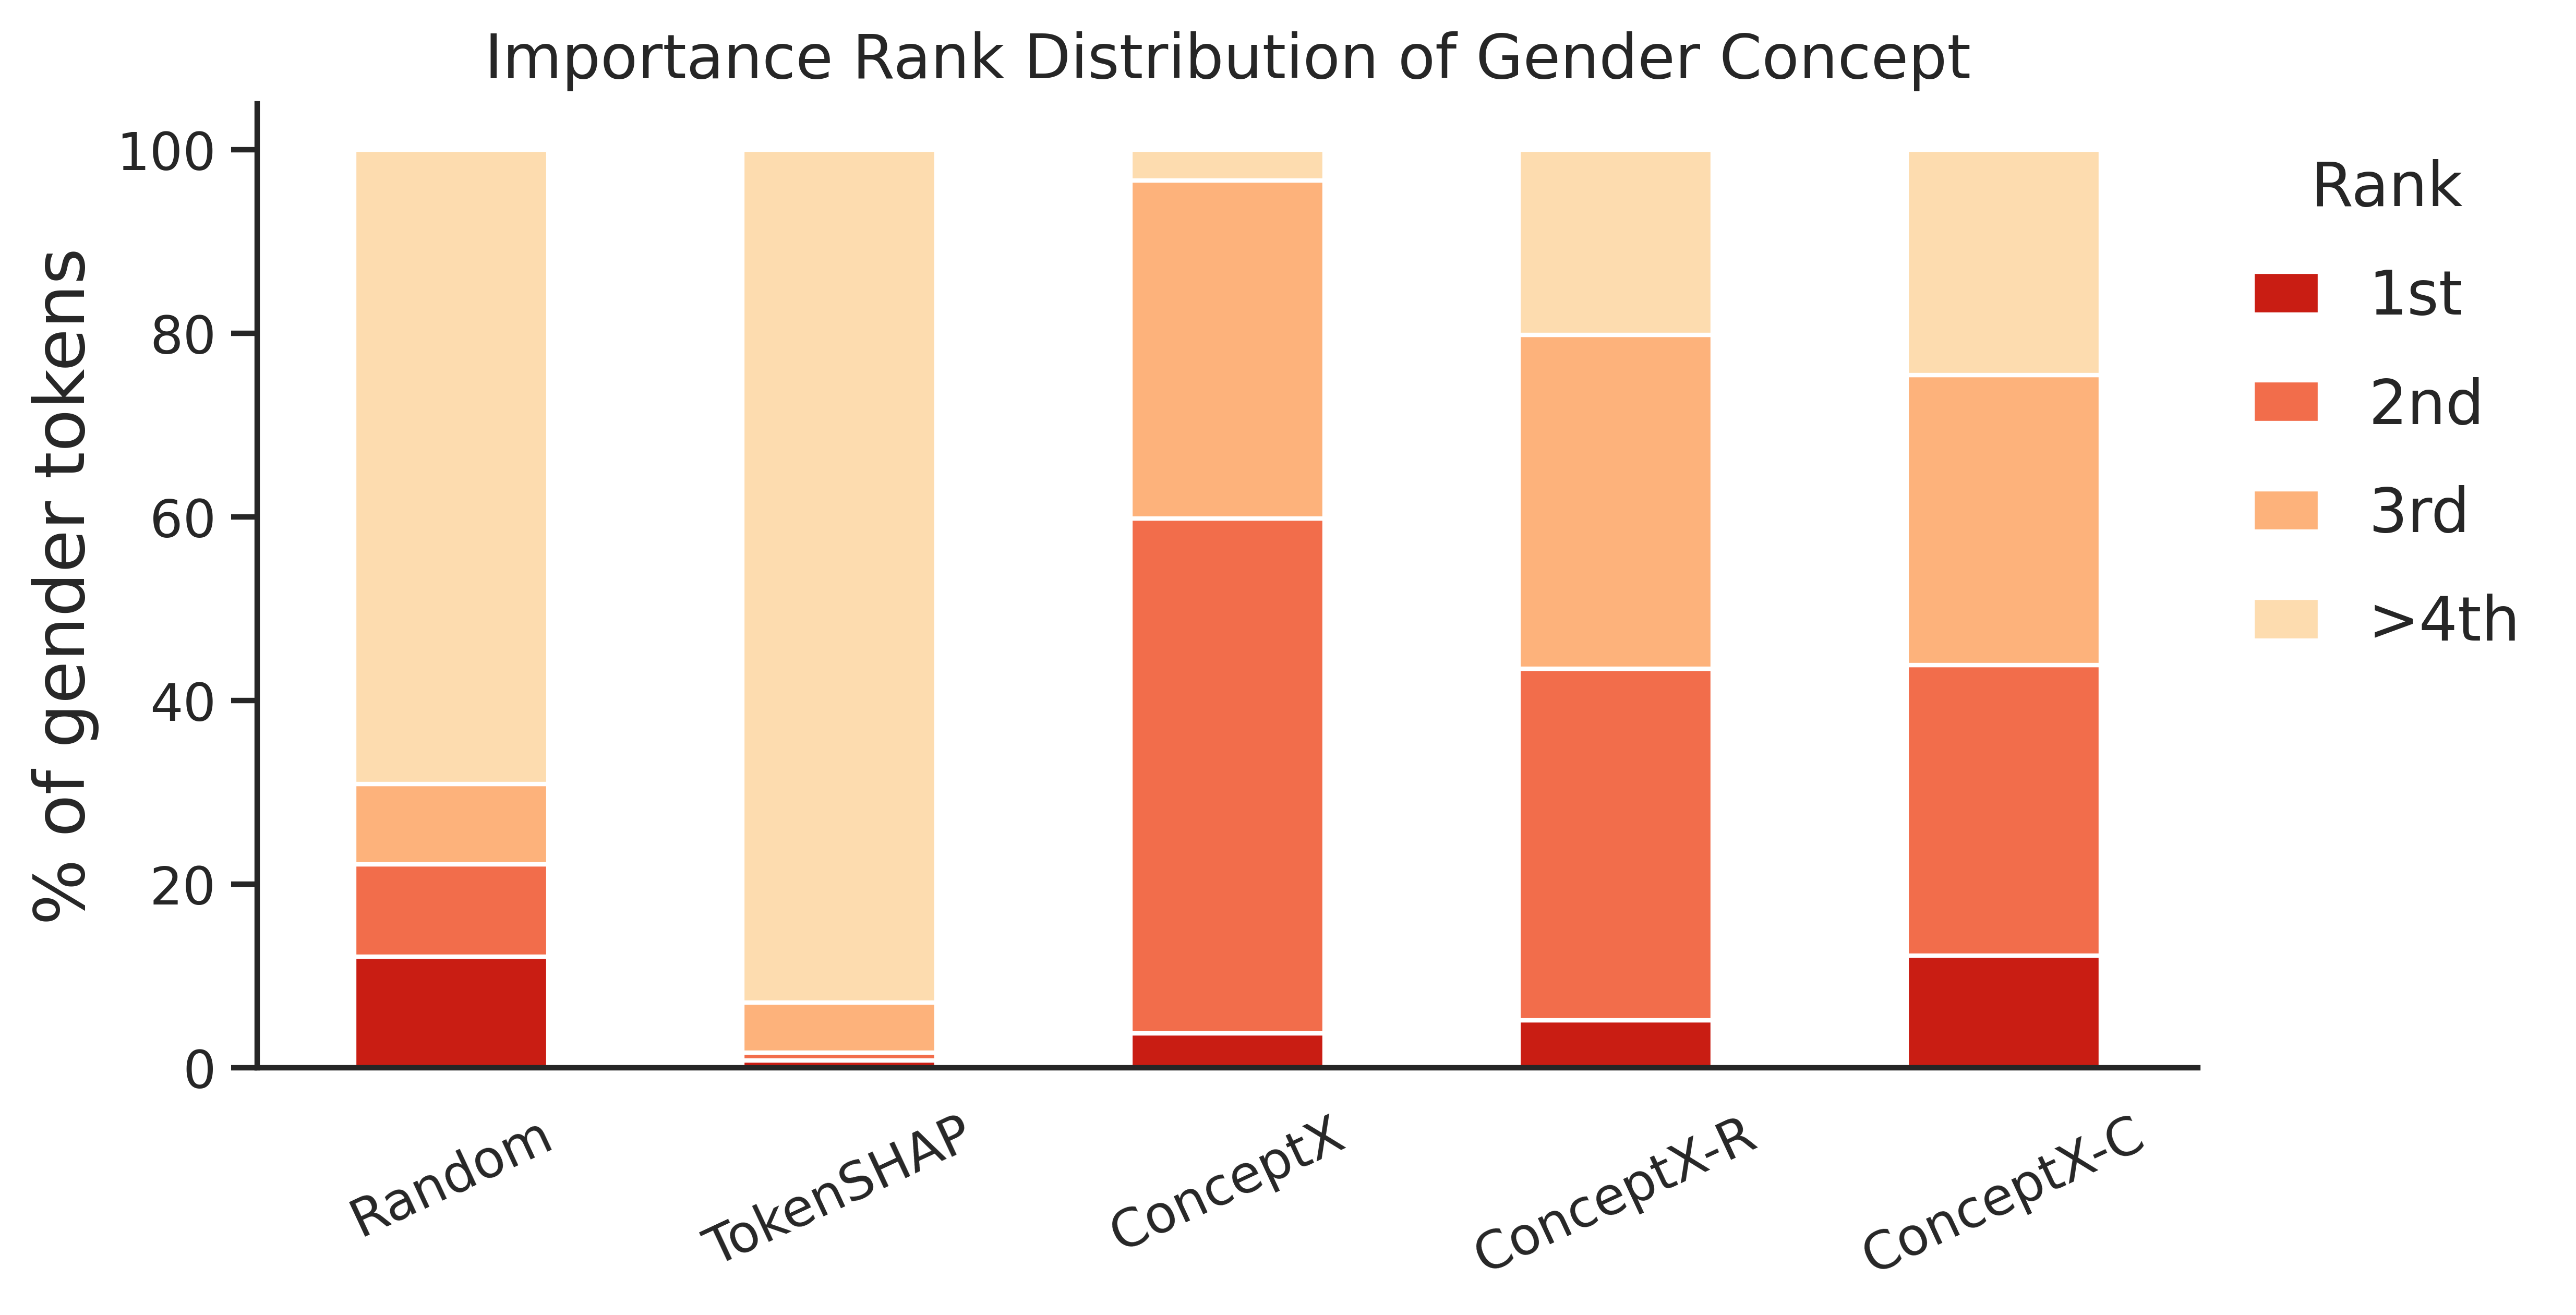

In [25]:
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})
# Plot with increasing hue from Viridis colormap
plt.figure(figsize=(4,4))
result.plot(kind='bar', stacked=True, color=sns.color_palette("OrRd_r", n_colors=len(result.columns)), width=0.5, edgecolor='white', figsize=(8,4))

plt.title('Importance Rank Distribution of Gender Concept', fontsize=14)
plt.xlabel('')
plt.ylabel('% of gender tokens', fontsize=16)
plt.xticks(rotation=25)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Move the legend outside on the upper right side of the plot
# Rewrite legend with custom labels and title
leg = plt.legend(labels=['1st', '2nd', '3rd', '>4th'], title='Rank', bbox_to_anchor=(1, 1), fontsize=14, loc='upper left', frameon=False, handlelength=1.1, labelspacing=0.8)
leg.get_title().set_fontsize('14')  # Increase legend title font size
for line in leg.get_lines():
    line.set_linewidth(3)  # Increase line width in legend

sns.despine()


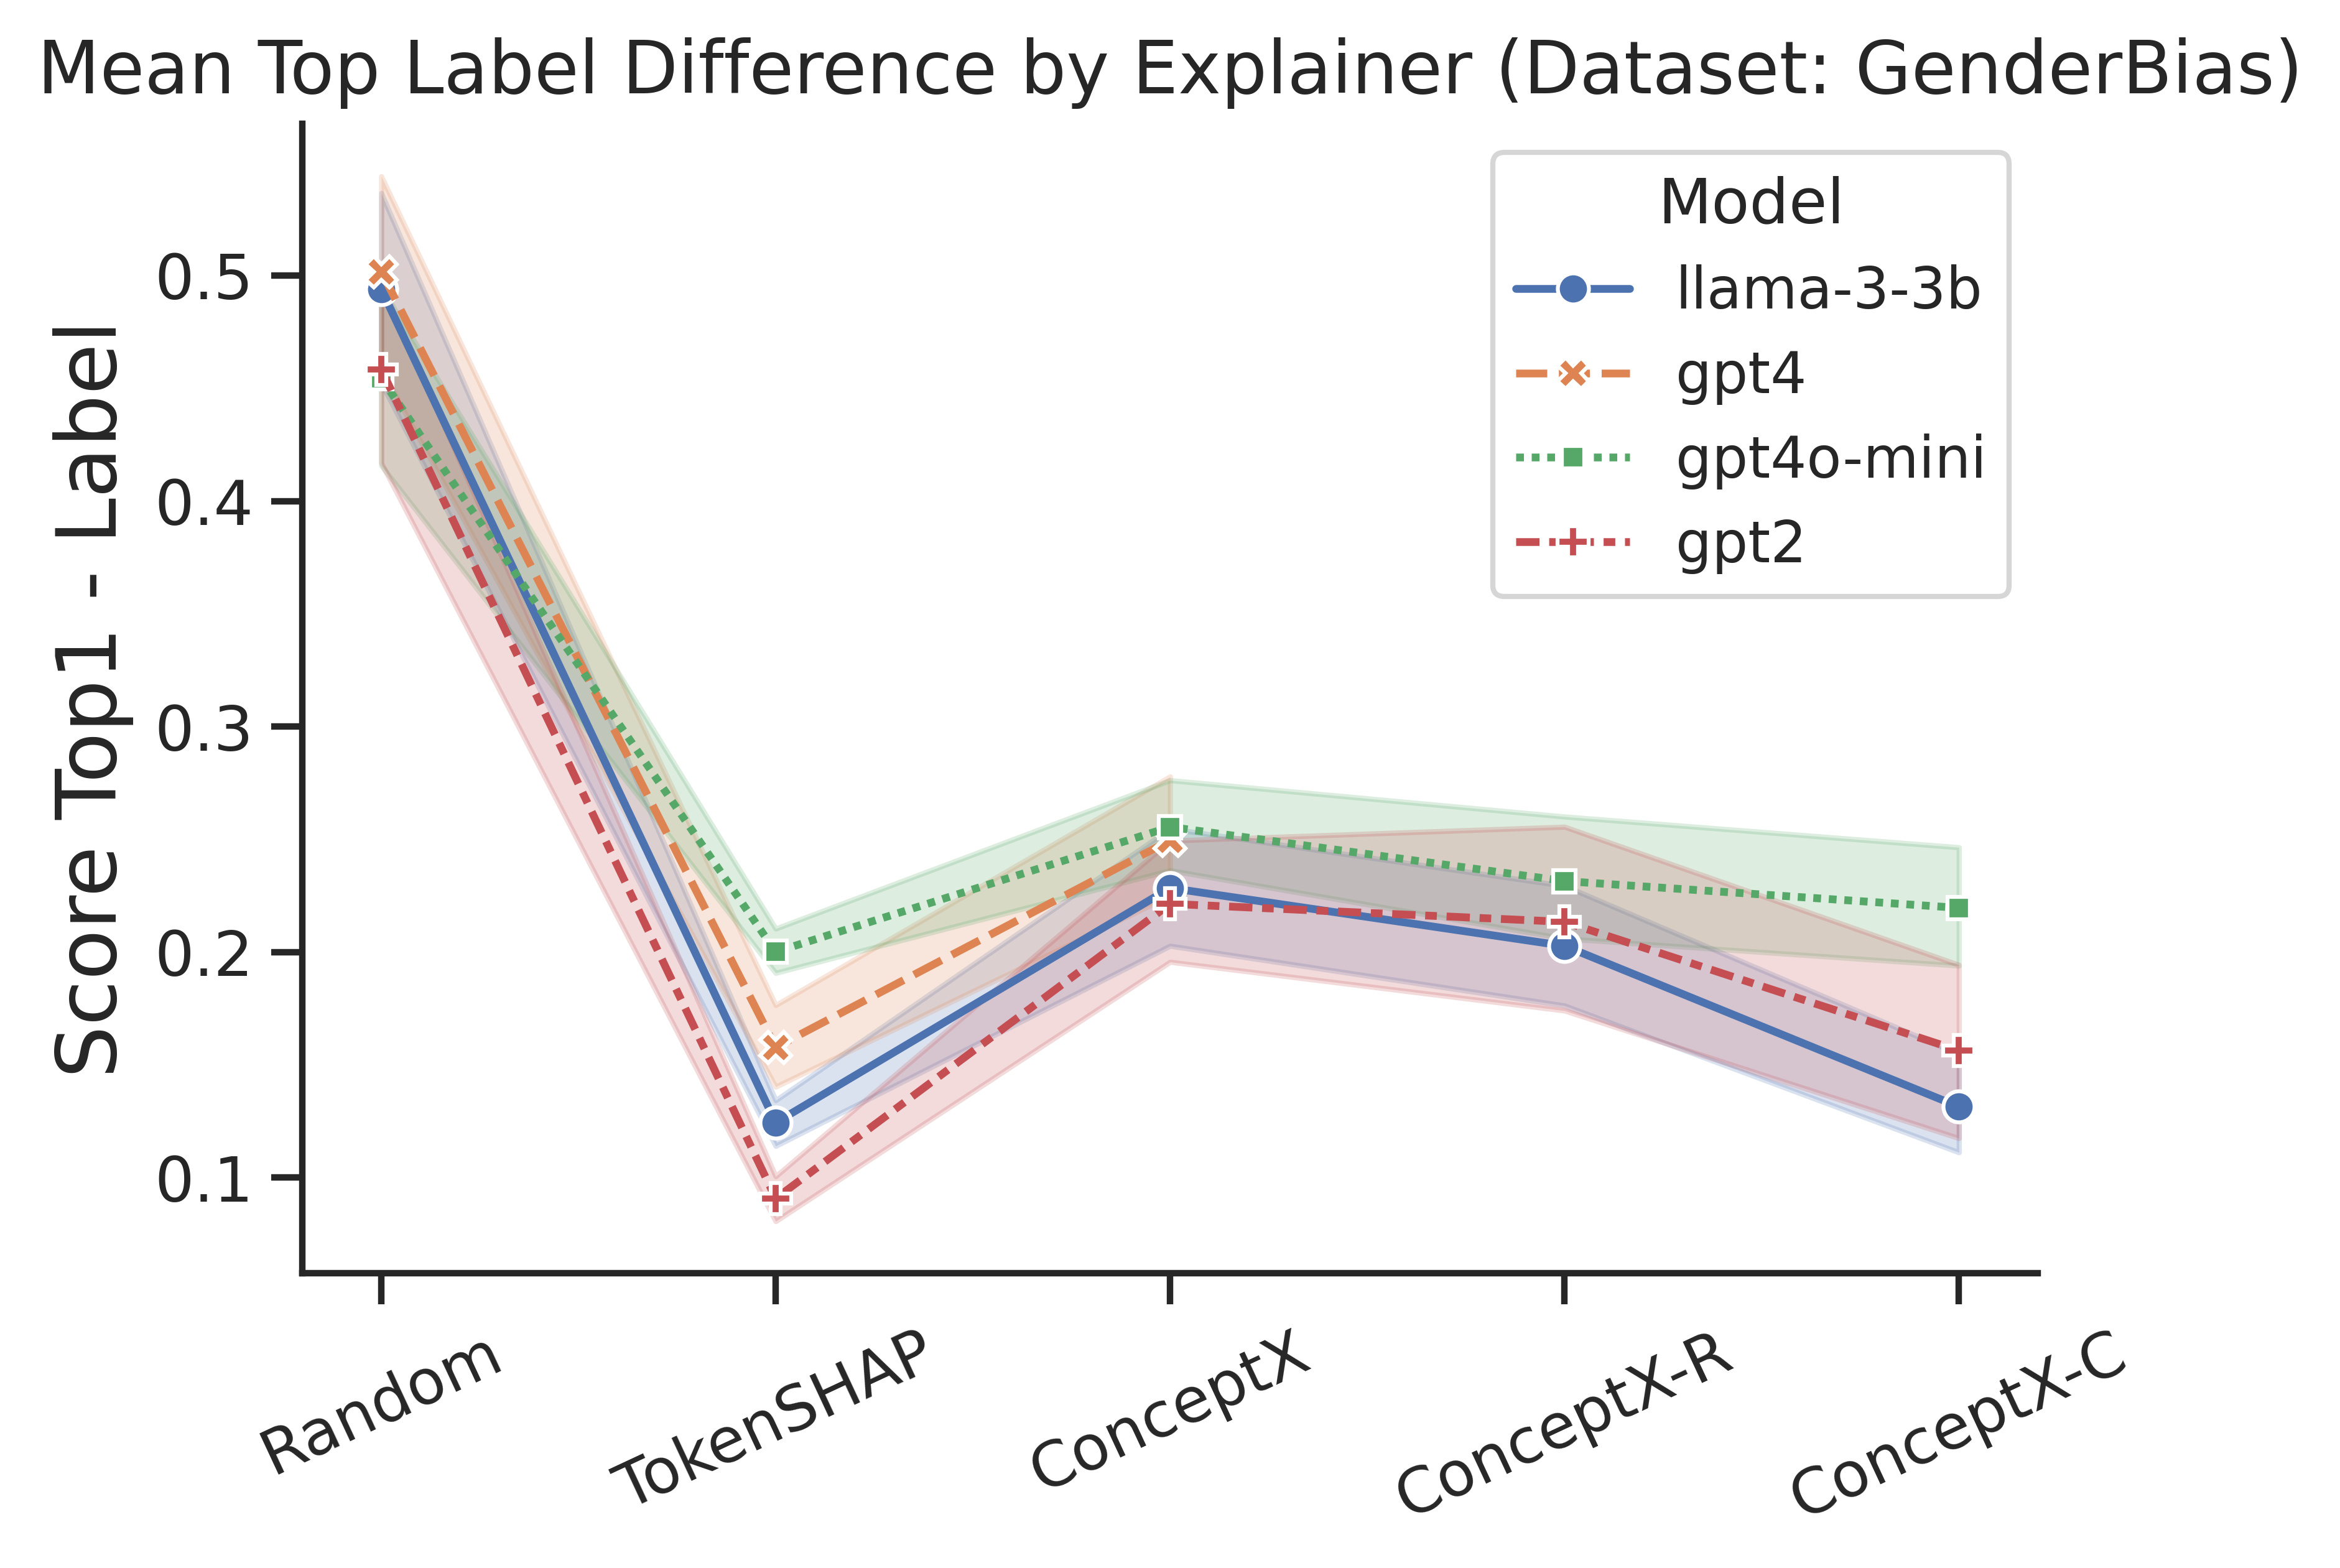

In [26]:
df = df_all[df_all["dataset"]==dataset]
df["explainer"] = df["explainer"].replace(explainer_map)
df["explainer"] = pd.Categorical(df["explainer"], categories=explainer_order, ordered=True)

sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})
# Plot
plt.figure(figsize=(6,4))
sns.lineplot(
    data=df, 
    x="explainer", 
    y="top_label_difference", 
    hue="model",  # Different models get different colors
    style="model",  # Different models get different line styles (dashes)
    markers=True  # Add markers for visibility
)

# Formatting
plt.xlabel('')
plt.ylabel("Score Top1 - Label", fontsize=16)
plt.title("Mean Top Label Difference by Explainer (Dataset: GenderBias)", fontsize=14)
plt.xticks(rotation=25)  # Rotate x-axis labels for better visibility
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=True)

plt.legend(title="Model")

sns.despine()
# Show plot
plt.show()